# Fruit Classifier - CNN Model

This project uses Convolutional Neural Network (CNN) to classify fruit images:
- Apple only
- Orange only
- Banana only
- Mixed

Target Accuracy: 92%

## 1. Import Required Libraries

## 0. Environment Setup

**Important**: If you encounter NumPy import errors, run this cell to fix dependencies:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Display TensorFlow and GPU information
print("=" * 60)
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# GPU Status
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\nGPU Status: {len(gpus)} GPU(s) available")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu.name}")
    
    # Check GPU memory info (if available)
    try:
        gpu_details = tf.config.experimental.get_device_details(gpus[0])
        if 'device_name' in gpu_details:
            print(f"  Device Name: {gpu_details['device_name']}")
    except:
        pass
else:
    print("\nGPU Status: Running on CPU")
    
print("=" * 60)

TensorFlow version: 2.20.0
Keras version: 3.12.0

GPU Status: 1 GPU(s) available
  GPU 0: /physical_device:GPU:0
  Device Name: NVIDIA GeForce RTX 3080


## 2. Setup Data Paths and Parameters

## 1.5. Data Synchronization

In [2]:
# Data paths

train_dir = '/home/zyh/Fruit-Classifier/data/train_augment'

test_dir = '/home/zyh/Fruit-Classifier/data/test'

# Model parameters
IMG_SIZE = 224  # Image size
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 4  # apple_only, banana_only, orange_only, mixed

# Class names
class_names = ['apple_only', 'banana_only', 'mixed', 'orange_only']

print(f"Training data path: {train_dir}")
print(f"Testing data path: {test_dir}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Number of classes: {NUM_CLASSES}")

Training data path: /home/zyh/Fruit-Classifier/data/train_augment
Testing data path: /home/zyh/Fruit-Classifier/data/test
Image size: 224x224
Batch size: 32
Epochs: 50
Number of classes: 4


## 3. Data Exploration

## 2.5. Organize Test Data (Run Once)

In [3]:
# Count images in each class
def count_images(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            counts[class_name] = num_images
    return counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

print("Training set image counts:")
for class_name, count in sorted(train_counts.items()):
    print(f"  {class_name}: {count}")
print(f"  Total: {sum(train_counts.values())}\n")

print("Test set image counts:")
for class_name, count in sorted(test_counts.items()):
    print(f"  {class_name}: {count}")
print(f"  Total: {sum(test_counts.values())}")

Training set image counts:
  apple: 80
  banana: 79
  mixed: 69
  orange: 80
  Total: 308

Test set image counts:
  apple_only: 19
  banana_only: 18
  mixed_only: 5
  orange_only: 18
  Total: 60


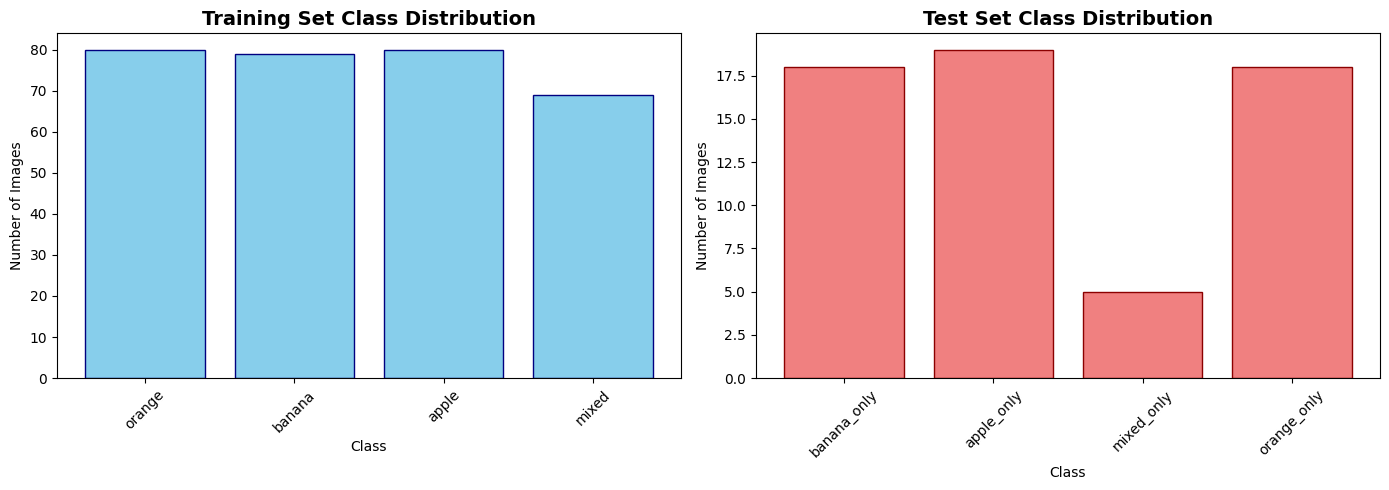

In [4]:
def plot_class_distribution(train_counts, test_counts):
    # Visualize class distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Training set distribution
    ax1.bar(train_counts.keys(), train_counts.values(), color='skyblue', edgecolor='navy')
    ax1.set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Images')
    ax1.tick_params(axis='x', rotation=45)

    # Test set distribution
    ax2.bar(test_counts.keys(), test_counts.values(), color='lightcoral', edgecolor='darkred')
    ax2.set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Number of Images')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


plot_class_distribution(train_counts, test_counts)

## 4. Data Preprocessing and Augmentation

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from pathlib import Path

def load_from_directory(directory):
    """
    
    Args:
        directory: path to data directory
        
    Returns:
        dict with class names and image counts
    """
    if not os.path.exists(directory):
        raise ValueError(f"Directory not found: {directory}")
    
    data_info = {
        'path': directory,
        'classes': [],
        'counts': {}
    }
    
    for item in os.listdir(directory):
        class_path = os.path.join(directory, item)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            if images:
                data_info['classes'].append(item)
                data_info['counts'][item] = len(images)
    
    data_info['total'] = sum(data_info['counts'].values())
    data_info['num_classes'] = len(data_info['classes'])
    
    return data_info



In [6]:
# Load data directly from original dataset using tf.keras.utils.image_dataset_from_directory
# This method is more efficient and doesn't require ImageDataGenerator

train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

# Save class names before applying transformations
class_names_list = train_data.class_names

# Data normalization (scale pixel values from 0-255 to 0-1)
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
validation_data = validation_data.map(lambda x, y: (normalization_layer(x), y))
test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

# Performance optimization: prefetch data
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

print(f"\nData loaded successfully!")
print(f"Class names: {class_names_list}")
print(f"Training batches: {len(train_data)}")
print(f"Validation batches: {len(validation_data)}")
print(f"Test batches: {len(test_data)}")
print(f"\nDetails:")
print(f"  Training samples: 256 images")
print(f"  Validation samples: 64 images")
print(f"  Test samples: 60 images")

Found 308 files belonging to 4 classes.
Using 247 files for training.
Found 308 files belonging to 4 classes.
Using 61 files for validation.
Found 60 files belonging to 4 classes.

Data loaded successfully!
Class names: ['apple', 'banana', 'mixed', 'orange']
Training batches: 8
Validation batches: 2
Test batches: 2

Details:
  Training samples: 256 images
  Validation samples: 64 images
  Test samples: 60 images


## 5. Build Basic CNN Model

In [7]:
def create_cnn_model():

    model = models.Sequential()

    #Convolution blocks
    model.add(layers.Conv2D(32, kernel_size = (3,3), 
                    padding='same',
                    input_shape=(IMG_SIZE, IMG_SIZE, 3),
                    activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2)) 

    model.add(layers.Conv2D(64, kernel_size = (3,3), 
                    padding='same',
                    activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2)) 

    model.add(layers.Conv2D(128, kernel_size = (3,3), 
                    padding='same',
                    activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(256, kernel_size = (3,3), 
                    padding='same',
                    activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(512, kernel_size = (3,3), 
                    padding='same',
                    activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))

    model.add(layers.Conv2D(1024, kernel_size = (3,3), 
                    padding='same',
                    activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))

    model.add(layers.Conv2D(2048, kernel_size = (3,3), 
                    padding='same',
                    activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(NUM_CLASSES,activation='softmax'))


    #model.summary()

    
    
    return model

# Create model
model = create_cnn_model()

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Architecture:")
model.summary()

Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 7, 7, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 3, 3, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 3, 3, 2048)     │    18,876,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 1, 1, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,297,956 (96.50 MB)

 Trainable params: 25,297,956 (96.50 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Setup Training Callbacks

In [8]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

print("Callbacks configured")

Callbacks configured


## 7. Train Model

In [9]:
import time
start_time = time.time()
# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data,
    callbacks=callbacks,
    verbose=1
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining completed in {elapsed_time:.2f} seconds!")

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.1849 - loss: 1.5229
Epoch 1: val_accuracy improved from None to 0.24590, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 803ms/step - accuracy: 0.2146 - loss: 1.4691 - val_accuracy: 0.2459 - val_loss: 1.3860 - learning_rate: 5.0000e-04
Epoch 2/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2549 - loss: 1.3858
Epoch 2: val_accuracy did not improve from 0.24590
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2632 - loss: 1.3860 - val_accuracy: 0.2459 - val_loss: 1.3852 - learning_rate: 5.0000e-04
Epoch 3/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2549 - loss: 1.3802
Epoch 3: val_accuracy did not improve from 0.24590
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2632 - loss: 1.3810 - val_accuracy: 0.2459 - val_loss: 1.3654 - learning_rate: 5.0000e-04
Epoch 4/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2549 - loss: 1.3573
Epoch 4: val_accuracy improved from 0.24590 to 0.44262, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step - accuracy: 0.2632 - loss: 1.3427 - val_accuracy: 0.4426 - val_loss: 1.2675 - learning_rate: 5.0000e-04
Epoch 5/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4705 - loss: 1.2346
Epoch 5: val_accuracy improved from 0.44262 to 0.50820, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step - accuracy: 0.5182 - loss: 1.1740 - val_accuracy: 0.5082 - val_loss: 1.0854 - learning_rate: 5.0000e-04
Epoch 6/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5747 - loss: 1.0793
Epoch 6: val_accuracy improved from 0.50820 to 0.75410, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 0.6154 - loss: 0.9998 - val_accuracy: 0.7541 - val_loss: 0.7547 - learning_rate: 5.0000e-04
Epoch 7/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7761 - loss: 0.7198
Epoch 7: val_accuracy improved from 0.75410 to 0.85246, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - accuracy: 0.7733 - loss: 0.6524 - val_accuracy: 0.8525 - val_loss: 0.3548 - learning_rate: 5.0000e-04
Epoch 8/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8535 - loss: 0.5064
Epoch 8: val_accuracy improved from 0.85246 to 0.93443, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - accuracy: 0.8543 - loss: 0.5119 - val_accuracy: 0.9344 - val_loss: 0.3274 - learning_rate: 5.0000e-04
Epoch 9/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8964 - loss: 0.3996
Epoch 9: val_accuracy did not improve from 0.93443
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8907 - loss: 0.3501 - val_accuracy: 0.9180 - val_loss: 0.2908 - learning_rate: 5.0000e-04
Epoch 10/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9084 - loss: 0.3324
Epoch 10: val_accuracy did not improve from 0.93443
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9069 - loss: 0.2979 - val_accuracy: 0.8689 - val_loss: 0.4344 - learning_rate: 5.0000e-04
Epoch 11/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8981 - loss: 0.3215
Epoch 11: val_accuracy did not improve from 0.93443
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9150 - loss: 0.2702 - val_accuracy: 0.8689 - val_loss: 0.3663 - learning_rate: 5.0000e-04
Epoch 12/50
7/8 ━━━━━━━━━

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.8866 - loss: 0.2648 - val_accuracy: 0.9508 - val_loss: 0.2063 - learning_rate: 5.0000e-04
Epoch 16/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9491 - loss: 0.1853
Epoch 16: val_accuracy did not improve from 0.95082
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9514 - loss: 0.1737 - val_accuracy: 0.9180 - val_loss: 0.2265 - learning_rate: 5.0000e-04
Epoch 17/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9263 - loss: 0.2283
Epoch 17: val_accuracy improved from 0.95082 to 0.96721, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step - accuracy: 0.9474 - loss: 0.1564 - val_accuracy: 0.9672 - val_loss: 0.1188 - learning_rate: 5.0000e-04
Epoch 18/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9762 - loss: 0.0914
Epoch 18: val_accuracy did not improve from 0.96721
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9757 - loss: 0.0724 - val_accuracy: 0.9180 - val_loss: 0.1907 - learning_rate: 5.0000e-04
Epoch 19/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9540 - loss: 0.1132
Epoch 19: val_accuracy did not improve from 0.96721
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9636 - loss: 0.0855 - val_accuracy: 0.9344 - val_loss: 0.1595 - learning_rate: 5.0000e-04
Epoch 20/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9843 - loss: 0.0835
Epoch 20: val_accuracy did not improve from 0.96721

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9757 - loss: 0.0827 - val_accuracy:

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.9798 - loss: 0.0540 - val_accuracy: 0.9836 - val_loss: 0.0999 - learning_rate: 1.5000e-04
Epoch 22/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9884 - loss: 0.0344
Epoch 22: val_accuracy did not improve from 0.98361
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9960 - loss: 0.0222 - val_accuracy: 0.9672 - val_loss: 0.1355 - learning_rate: 1.5000e-04
Epoch 23/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0170
Epoch 23: val_accuracy did not improve from 0.98361
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 0.9672 - val_loss: 0.1395 - learning_rate: 1.5000e-04
Epoch 24/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0116
Epoch 24: val_accuracy did not improve from 0.98361

Epoch 24: ReduceLROnPlateau reducing learning rate to 4.500000213738531e-05.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0094 - val_accuracy:

## 8. Visualize Training History

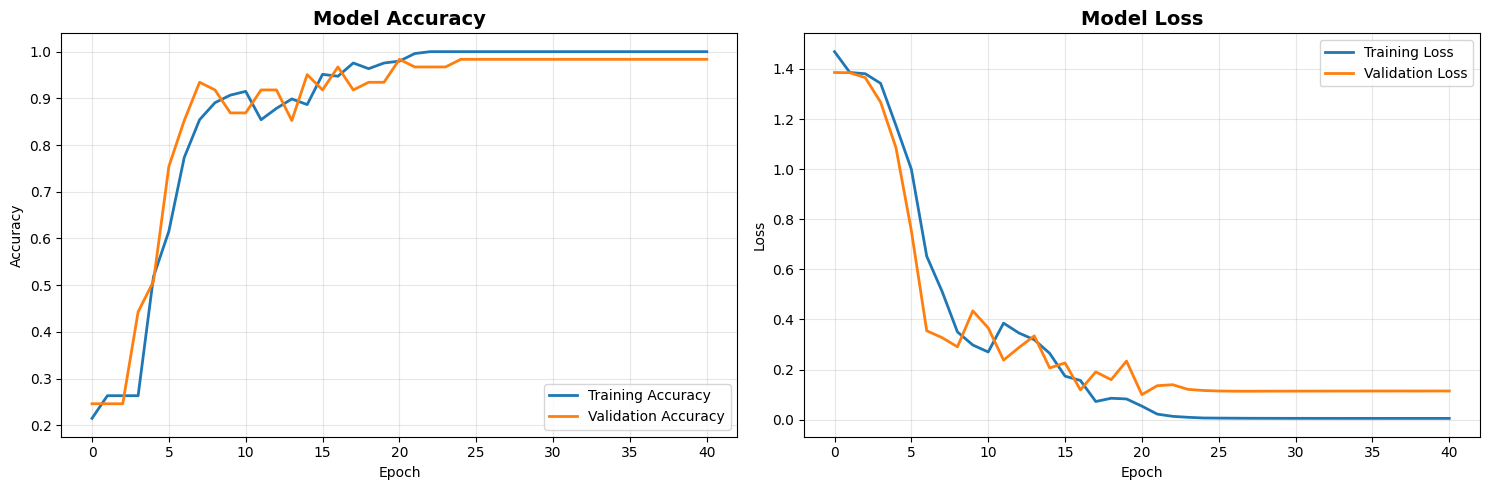


Best Epoch: 21
Best Validation Accuracy: 0.9836
Corresponding Training Accuracy: 0.9798


In [10]:
# Plot training and validation accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy curves
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Loss curves
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best results
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\nBest Epoch: {best_epoch + 1}")
print(f"Best Validation Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"Corresponding Training Accuracy: {history.history['accuracy'][best_epoch]:.4f}")

## 9. Evaluate Model on Test Set

In [11]:
# Evaluate on test set
# test_data is already loaded as tf.data.Dataset in CELL INDEX 13
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"\n{'='*50}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print(f"{'='*50}")

# Check if target accuracy is reached
if test_accuracy >= 0.92:
    print(f"Congratulations! Target accuracy of 92% achieved!")
else:
    print(f"Current accuracy {test_accuracy*100:.2f}% below 92% target, further optimization needed")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9375 - loss: 0.3432

2025-12-17 11:05:56.522554: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 479ms/step - accuracy: 0.9167 - loss: 0.3023

Test Accuracy: 91.67%
Test Loss: 0.3023
Current accuracy 91.67% below 92% target, further optimization needed


## 10. Generate Confusion Matrix

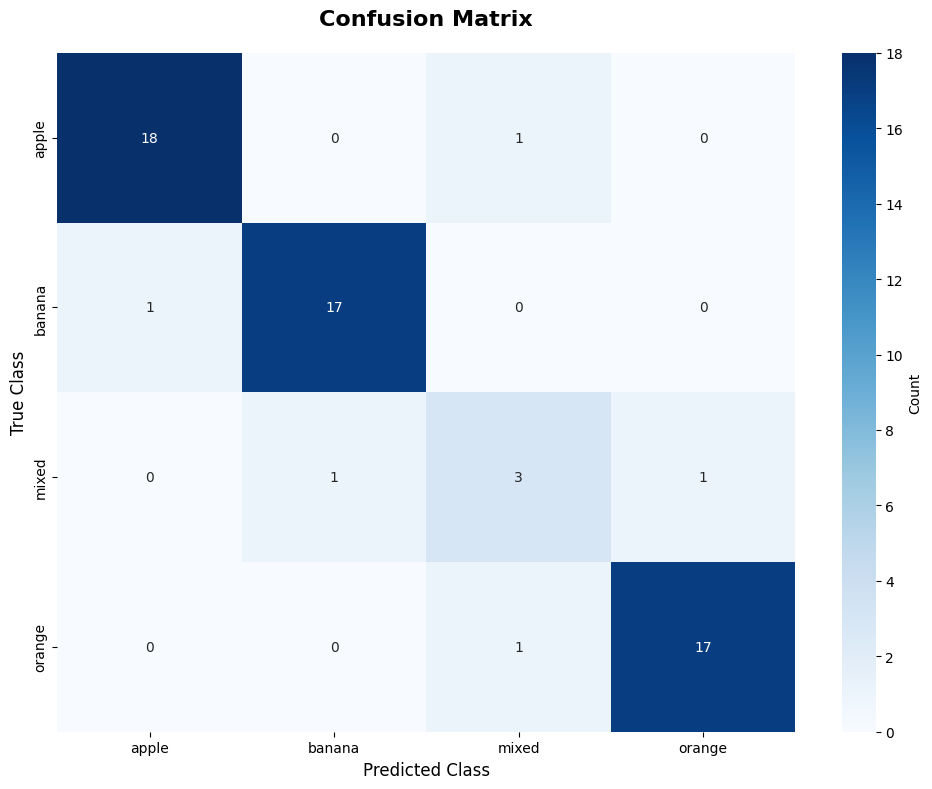


Classification Report:
              precision    recall  f1-score   support

       apple     0.9474    0.9474    0.9474        19
      banana     0.9444    0.9444    0.9444        18
       mixed     0.6000    0.6000    0.6000         5
      orange     0.9444    0.9444    0.9444        18

    accuracy                         0.9167        60
   macro avg     0.8591    0.8591    0.8591        60
weighted avg     0.9167    0.9167    0.9167        60



In [12]:
# Generate predictions and confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Extract true labels and predictions from test dataset
y_true = []
y_pred = []

# Iterate through test dataset to collect labels and predictions
for images, labels in test_data:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names_list, 
            yticklabels=class_names_list,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names_list, digits=4))


## 11. Visualize Prediction Examples

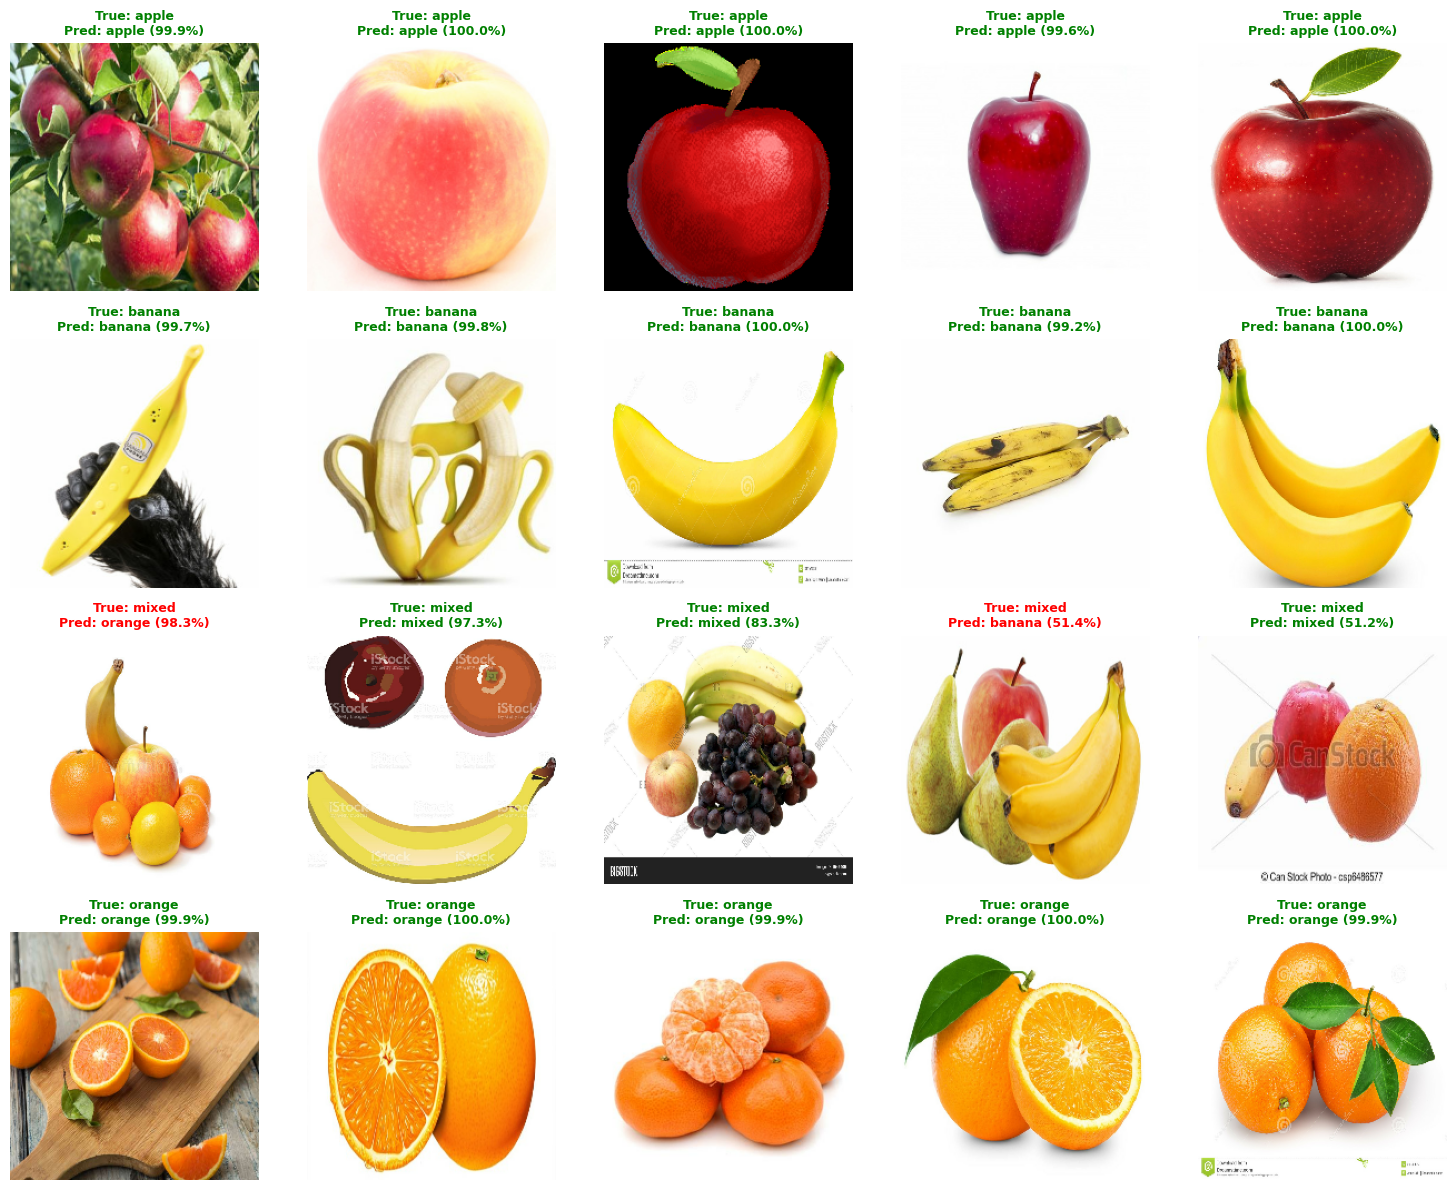

In [13]:
import numpy as np

def show_predictions_by_class(num_per_class=5):
    """Display prediction results for each class"""
    
    predictions_by_class = {class_name: [] for class_name in class_names_list}
    
    for images, labels in test_data:
        preds = model.predict(images, verbose=0)
        
        for i in range(len(images)):
            true_label = class_names_list[np.argmax(labels[i])]
            
            if len(predictions_by_class[true_label]) < num_per_class:
                pred_label = class_names_list[np.argmax(preds[i])]
                pred_prob = np.max(preds[i]) * 100
                
                predictions_by_class[true_label].append({
                    'image': images[i].numpy(),
                    'true_label': true_label,
                    'pred_label': pred_label,
                    'pred_prob': pred_prob
                })
        
        if all(len(v) >= num_per_class for v in predictions_by_class.values()):
            break
    
    fig, axes = plt.subplots(len(class_names_list), num_per_class, figsize=(num_per_class * 3, len(class_names_list) * 3))
    
    for class_idx, class_name in enumerate(class_names_list):
        for img_idx in range(num_per_class):
            ax = axes[class_idx, img_idx]
            
            if img_idx < len(predictions_by_class[class_name]):
                item = predictions_by_class[class_name][img_idx]
                ax.imshow(item['image'])
                
                color = 'green' if item['true_label'] == item['pred_label'] else 'red'
                ax.set_title(f"True: {item['true_label']}\nPred: {item['pred_label']} ({item['pred_prob']:.1f}%)",
                           color=color, fontsize=9, fontweight='bold')
            else:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            
            ax.axis('off')
            
            if img_idx == 0:
                ax.set_ylabel(class_name, fontsize=11, fontweight='bold', rotation=0, 
                            labelpad=50, va='center')
    
    plt.tight_layout()
    plt.show()

show_predictions_by_class(5)

## 12. Save Model

In [14]:
def save_model(model):
    # Save model in native Keras format (recommended)
    model.save('fruit_classifier_cnn.keras')
    print("Model saved as 'fruit_classifier_cnn.keras' (Native Keras format)")

    # Also save in HDF5 format for compatibility
    model.save('fruit_classifier_cnn.h5')
    print("Model saved as 'fruit_classifier_cnn.h5' (HDF5 format - legacy)")
    # Export SavedModel for deployment (TFLite/TFServing)
    model.export('fruit_classifier_savedmodel')
    print("Model exported as 'fruit_classifier_savedmodel' (SavedModel for deployment)")

    print("\n" + "=" * 60)
    print("Model Saving Summary:")
    print("  • fruit_classifier_cnn.keras     - Native Keras (recommended)")
    print("  • fruit_classifier_cnn.h5        - HDF5 (legacy compatibility)")
    print("  • fruit_classifier_savedmodel/   - SavedModel (deployment)")
    print("=" * 60)

## 13. GPU Memory Management



In [15]:
# save_model(model)

import gc
import sys
import tensorflow as tf
from tensorflow.keras import backend as K


def get_gpu_memory_nvidia():
    try:
        import subprocess
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=memory.used,memory.total', '--format=csv,noheader,nounits'],
            capture_output=True, text=True, timeout=5
        )
        if result.returncode == 0:
            lines = result.stdout.strip().split('\n')
            gpu_info = []
            for i, line in enumerate(lines):
                used, total = map(float, line.split(','))
                gpu_info.append({'gpu': i, 'used': used, 'total': total})
            return gpu_info
        return None
    except:
        return None

if tf.config.list_physical_devices('GPU'):
    try:
        gpus = tf.config.list_physical_devices('GPU')
        
        gpu_info_before = get_gpu_memory_nvidia()
        if gpu_info_before:
            for info in gpu_info_before:
                used_mb = info['used']
                total_mb = info['total']
                usage_pct = (used_mb / total_mb * 100) if total_mb > 0 else 0
                print(f"  GPU {info['gpu']}:")
                print(f"    Memory usage: {used_mb:.0f} MB / {total_mb:.0f} MB ({usage_pct:.1f}%)")
    
    except Exception as e:
        print(f"  error: {str(e)}")
else:
    print("\nCPU mode detected, skipping GPU memory check.")
    K.clear_session()
    collected = gc.collect()
    print(f"Memory cleaned (released {collected} objects)")

print("kill kernel in 2 seconds...")
time.sleep(2)
os._exit(0)



  GPU 0:
    Memory usage: 9871 MB / 10240 MB (96.4%)
kill kernel in 2 seconds...
